# Environement Setup Check

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from shutil import copy
import random
import math
import collections
from collections import defaultdict

import tensorflow as tf
from tensorflow import keras as k

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.layers import Dense, Dropout
from keras.layers import GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras import regularizers
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.regularizers import l2

from keras.utils import plot_model

from keras import layers

from keras.callbacks import ModelCheckpoint

from keras.models import load_model

from sklearn.preprocessing import label_binarize
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import seaborn as sns

In [4]:
# Set seed
seed_value = 1234
random.seed(seed_value) # Set `python` built-in pseudo-random generator

np.random.seed(seed_value) # Set `numpy` random generator at a fixed value

tf.random.set_seed(seed_value) # Set `tensorflow` pseudo-random generator at a fixed value

# Loading Datasets

In [5]:
def prepare_data(filepath, src, dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')

    for food in classes_images.keys():
        #print("\nCopying images into ",food)
        if not os.path.exists(os.path.join(dest,food)):
            os.makedirs(os.path.join(dest,food))
        for i in classes_images[food]:
            copy(os.path.join(src,food,i), os.path.join(dest,food,i))
    print("Copying Done!")


In [6]:
# print("Creating train data...")
# prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')
# print("Creating test data...")
# prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating train data...
Copying Done!
Creating test data...
Copying Done!


# Pre-processing

In [9]:
N_CLASS = 101
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 128 # converge faster

src_train =  'food-101/train'
src_test = 'food-101/test'

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

print("Training images:")
train_generator = train_datagen.flow_from_directory(src_train,
                                                    target_size=IMAGE_SHAPE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')
print("Validating images:")
validation_generator = test_datagen.flow_from_directory(src_test,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')


Training images:
Found 75750 images belonging to 101 classes.
Validating images:
Found 25250 images belonging to 101 classes.


# Training

**Change the learning rate over epochs**

In [11]:
from keras.callbacks import LearningRateScheduler

def scheduler(epoch):
    initial_lr = 0.005
    decay_rate = 0.95 # decrease 5% per epoch
    lr = initial_lr * math.pow(decay_rate, epoch)
    return lr

## Unfreeze last 4 layers

In [17]:
#Callback for model savingand early stopping for preventing overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# ModelCheckpoint callback - save best weights
checkpoint_last_4 = ModelCheckpoint(filepath='Vgg16Checkpoints/vgg.weights.full.last4.hdf5',
                                  save_best_only=True,
                                  verbose=1)
checkpoint_last_8 = ModelCheckpoint(filepath='Vgg16Checkpoints/vgg.weights.full.last8.hdf5',
                                  save_best_only=True,
                                  verbose=1)

lrScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

# callbacks_list = [checkpoint_last_4,stop_early,lrScheduler]

In [14]:
# lr starts with 0.005, Barch size 128 
vgg16 = VGG16(weights='imagenet', include_top=False)

for layer in vgg16.layers[:-4]:
    layer.trainable = False
for layer in vgg16.layers[-4:]:
    layer.trainable = True

x = vgg16.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(2048, activation='relu') (x)
x = layers.Dense(2048, activation='relu') (x)
x = layers.Dropout(0.2)(x)

predictions = layers.Dense(N_CLASS, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model_full = k.Model(inputs=vgg16.input, outputs=predictions)

model_full.compile(optimizer=SGD(learning_rate = 0.005, momentum = 0.9),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history_full = model_full.fit(train_generator,
               validation_data=validation_generator,
               epochs=50,  # Train for 30 epochs
               verbose=1,
               callbacks = [checkpoint_last_4,stop_early,lrScheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.005.
Epoch 1/50
592/592 [==============================] - ETA: 0s - loss: 4.5048 - accuracy: 0.1383
Epoch 1: val_loss improved from inf to 3.31057, saving model to Vgg16Checkpoints\vgg.weights.full.last4.hdf5
592/592 [==============================] - 618s 1s/step - loss: 4.5048 - accuracy: 0.1383 - val_loss: 3.3106 - val_accuracy: 0.3009 - lr: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.00475.
Epoch 2/50
592/592 [==============================] - ETA: 0s - loss: 3.2670 - accuracy: 0.3118
Epoch 2: val_loss improved from 3.31057 to 2.76286, saving model to Vgg16Checkpoints\vgg.weights.full.last4.hdf5
592/592 [==============================] - 715s 1s/step - loss: 3.2670 - accuracy: 0.3118 - val_loss: 2.7629 - val_accuracy: 0.3860 - lr: 0.0047

Epoch 3: LearningRateScheduler setting learning rate to 0.0045125.
Epoch 3/50
592/592 [==============================] - ETA: 0s - loss: 2.7982 - accuracy: 0.3786
Ep


Epoch 20: LearningRateScheduler setting learning rate to 0.0018867680126765363.
Epoch 20/50
592/592 [==============================] - ETA: 0s - loss: 1.4800 - accuracy: 0.6356
Epoch 20: val_loss improved from 1.44079 to 1.43498, saving model to Vgg16Checkpoints\vgg.weights.full.last4.hdf5
592/592 [==============================] - 372s 628ms/step - loss: 1.4800 - accuracy: 0.6356 - val_loss: 1.4350 - val_accuracy: 0.6459 - lr: 0.0019

Epoch 21: LearningRateScheduler setting learning rate to 0.0017924296120427094.
Epoch 21/50
592/592 [==============================] - ETA: 0s - loss: 1.4547 - accuracy: 0.6411
Epoch 21: val_loss improved from 1.43498 to 1.43269, saving model to Vgg16Checkpoints\vgg.weights.full.last4.hdf5
592/592 [==============================] - 372s 628ms/step - loss: 1.4547 - accuracy: 0.6411 - val_loss: 1.4327 - val_accuracy: 0.6465 - lr: 0.0018

Epoch 22: LearningRateScheduler setting learning rate to 0.001702808131440574.
Epoch 22/50
592/592 [===================


Epoch 41: LearningRateScheduler setting learning rate to 0.0006425607828255156.
Epoch 41/50
592/592 [==============================] - ETA: 0s - loss: 1.0820 - accuracy: 0.7284
Epoch 41: val_loss did not improve from 1.34976
592/592 [==============================] - 372s 629ms/step - loss: 1.0820 - accuracy: 0.7284 - val_loss: 1.3664 - val_accuracy: 0.6729 - lr: 6.4256e-04

Epoch 42: LearningRateScheduler setting learning rate to 0.0006104327436842398.
Epoch 42/50
592/592 [==============================] - ETA: 0s - loss: 1.0709 - accuracy: 0.7326
Epoch 42: val_loss did not improve from 1.34976
592/592 [==============================] - 374s 631ms/step - loss: 1.0709 - accuracy: 0.7326 - val_loss: 1.3697 - val_accuracy: 0.6693 - lr: 6.1043e-04


In [15]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

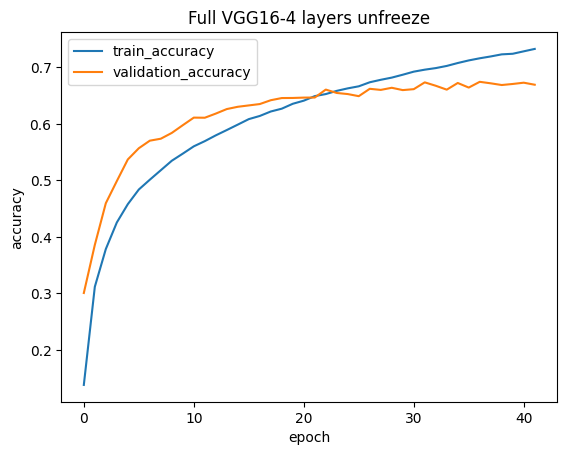

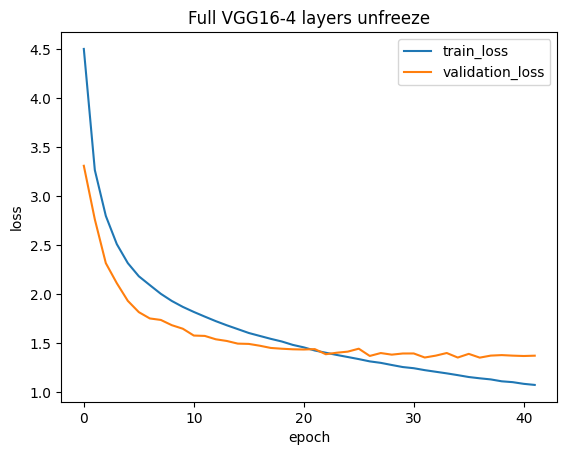

In [16]:
plot_accuracy(history_full,'Full VGG16-4 layers unfreeze')
plot_loss(history_full,'Full VGG16-4 layers unfreeze')

## Unfreeze last 8 layers

In [18]:
# lr starts with 0.005, Barch size 128 
vgg16 = VGG16(weights='imagenet', include_top=False)

for layer in vgg16.layers[:-8]:
    layer.trainable = False
for layer in vgg16.layers[-8:]:
    layer.trainable = True

x = vgg16.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(2048, activation='relu') (x)
x = layers.Dense(2048, activation='relu') (x)
x = layers.Dropout(0.2)(x)

predictions = layers.Dense(N_CLASS, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model_full2 = k.Model(inputs=vgg16.input, outputs=predictions)

model_full2.compile(optimizer=SGD(learning_rate = 0.005, momentum = 0.9),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history_full2 = model_full2.fit(train_generator,
               validation_data=validation_generator,
               epochs=50,  # Train for 30 epochs
               verbose=1,
               callbacks = [checkpoint_last_8,stop_early,lrScheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.005.
Epoch 1/50
592/592 [==============================] - ETA: 0s - loss: 4.3319 - accuracy: 0.1699
Epoch 1: val_loss improved from inf to 2.99509, saving model to Vgg16Checkpoints\vgg.weights.full.last8.hdf5
592/592 [==============================] - 379s 633ms/step - loss: 4.3319 - accuracy: 0.1699 - val_loss: 2.9951 - val_accuracy: 0.3777 - lr: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.00475.
Epoch 2/50
592/592 [==============================] - ETA: 0s - loss: 2.9388 - accuracy: 0.3820
Epoch 2: val_loss improved from 2.99509 to 2.44798, saving model to Vgg16Checkpoints\vgg.weights.full.last8.hdf5
592/592 [==============================] - 371s 626ms/step - loss: 2.9388 - accuracy: 0.3820 - val_loss: 2.4480 - val_accuracy: 0.4558 - lr: 0.0047

Epoch 3: LearningRateScheduler setting learning rate to 0.0045125.
Epoch 3/50
592/592 [==============================] - ETA: 0s - loss: 2.3884 - accuracy: 0.4


Epoch 21: LearningRateScheduler setting learning rate to 0.0017924296120427094.
Epoch 21/50
592/592 [==============================] - ETA: 0s - loss: 0.8188 - accuracy: 0.7963
Epoch 21: val_loss did not improve from 1.10621
592/592 [==============================] - 374s 631ms/step - loss: 0.8188 - accuracy: 0.7963 - val_loss: 1.1261 - val_accuracy: 0.7358 - lr: 0.0018


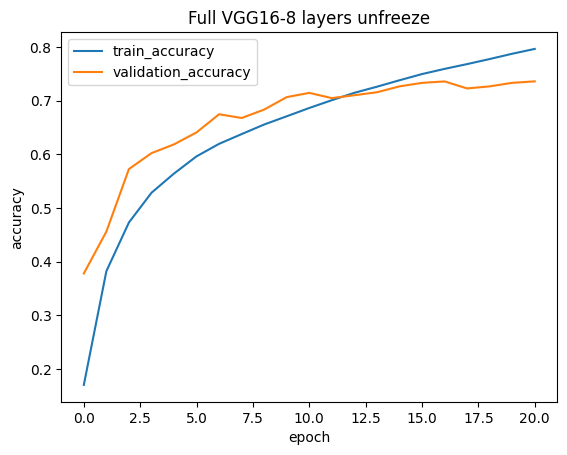

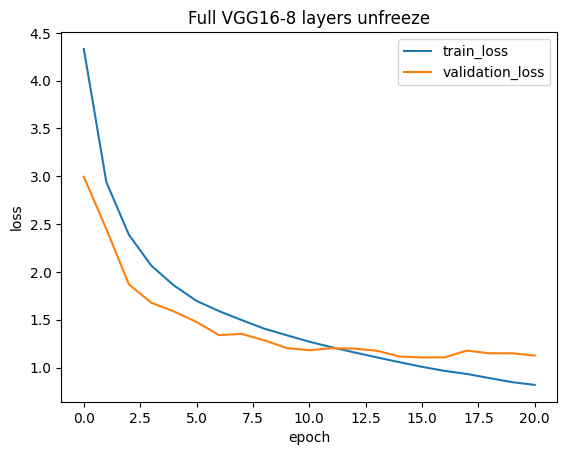

In [19]:
plot_accuracy(history_full2,'Full VGG16-8 layers unfreeze')
plot_loss(history_full2,'Full VGG16-8 layers unfreeze')

# Evaluation

In [70]:
model_path = 'Vgg16Checkpoints/vgg.weights.full.last8.hdf5'

# Load the model
model = load_model(model_path)

# Prepare the test data
test_generator = test_datagen.flow_from_directory(
    src_test,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get the true labels and predicted probabilities
y_true = test_generator.classes
y_true = label_binarize(y_true, classes=range(len(test_generator.class_indices)))
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)


# Classification Report
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=test_generator.class_indices.keys()))


Found 25250 images belonging to 101 classes.
198/198 [==============================] - 37s 184ms/step
Classification Report:
                         precision    recall  f1-score   support

              apple_pie       0.51      0.38      0.44       250
         baby_back_ribs       0.78      0.70      0.74       250
                baklava       0.88      0.77      0.82       250
         beef_carpaccio       0.68      0.82      0.74       250
           beef_tartare       0.53      0.82      0.65       250
             beet_salad       0.55      0.72      0.62       250
               beignets       0.86      0.81      0.83       250
               bibimbap       0.93      0.84      0.88       250
          bread_pudding       0.61      0.46      0.52       250
      breakfast_burrito       0.67      0.53      0.59       250
             bruschetta       0.76      0.60      0.67       250
           caesar_salad       0.73      0.86      0.79       250
                cannoli     

#### Food categories with the lowest 10 scores

In [93]:
class_report_dict = classification_report(y_true_classes, y_pred_classes, target_names=test_generator.class_indices.keys(), output_dict=True)

# Get a list of class names
class_names = list(class_report_dict.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'

# Define a custom sorting function based on F1-Score
def sort_by_f1_score(class_name):
    return class_report_dict[class_name]['f1-score']

# Sort the class names based on F1-Score (you can change the metric if needed)
sorted_classes = sorted(class_names, key=sort_by_f1_score)

# Get the 10 classes with the lowest F1-Scores
lowest_10_classes = sorted_classes[:10]

# Print the results
for class_name in lowest_10_classes:
    metrics = class_report_dict[class_name]
    print(f"Class: {class_name}, F1-Score: {metrics['f1-score']}, Precision: {metrics['precision']}, Recall: {metrics['recall']}")

Class: apple_pie, F1-Score: 0.4393592677345538, Precision: 0.5133689839572193, Recall: 0.384
Class: steak, F1-Score: 0.45491803278688525, Precision: 0.46638655462184875, Recall: 0.444
Class: pork_chop, F1-Score: 0.45999999999999996, Precision: 0.6133333333333333, Recall: 0.368
Class: chocolate_mousse, F1-Score: 0.5073170731707316, Precision: 0.65, Recall: 0.416
Class: bread_pudding, F1-Score: 0.5217391304347827, Precision: 0.6096256684491979, Recall: 0.456
Class: filet_mignon, F1-Score: 0.5228758169934642, Precision: 0.4419889502762431, Recall: 0.64
Class: ravioli, F1-Score: 0.5277161862527716, Precision: 0.5920398009950248, Recall: 0.476
Class: ceviche, F1-Score: 0.5312046444121916, Precision: 0.4168564920273349, Recall: 0.732
Class: foie_gras, F1-Score: 0.536082474226804, Precision: 0.5531914893617021, Recall: 0.52
Class: tuna_tartare, F1-Score: 0.5581395348837209, Precision: 0.5919282511210763, Recall: 0.528


#### Heatmap

Text(0.5, 1.0, 'Confusion Matrix Heatmap')

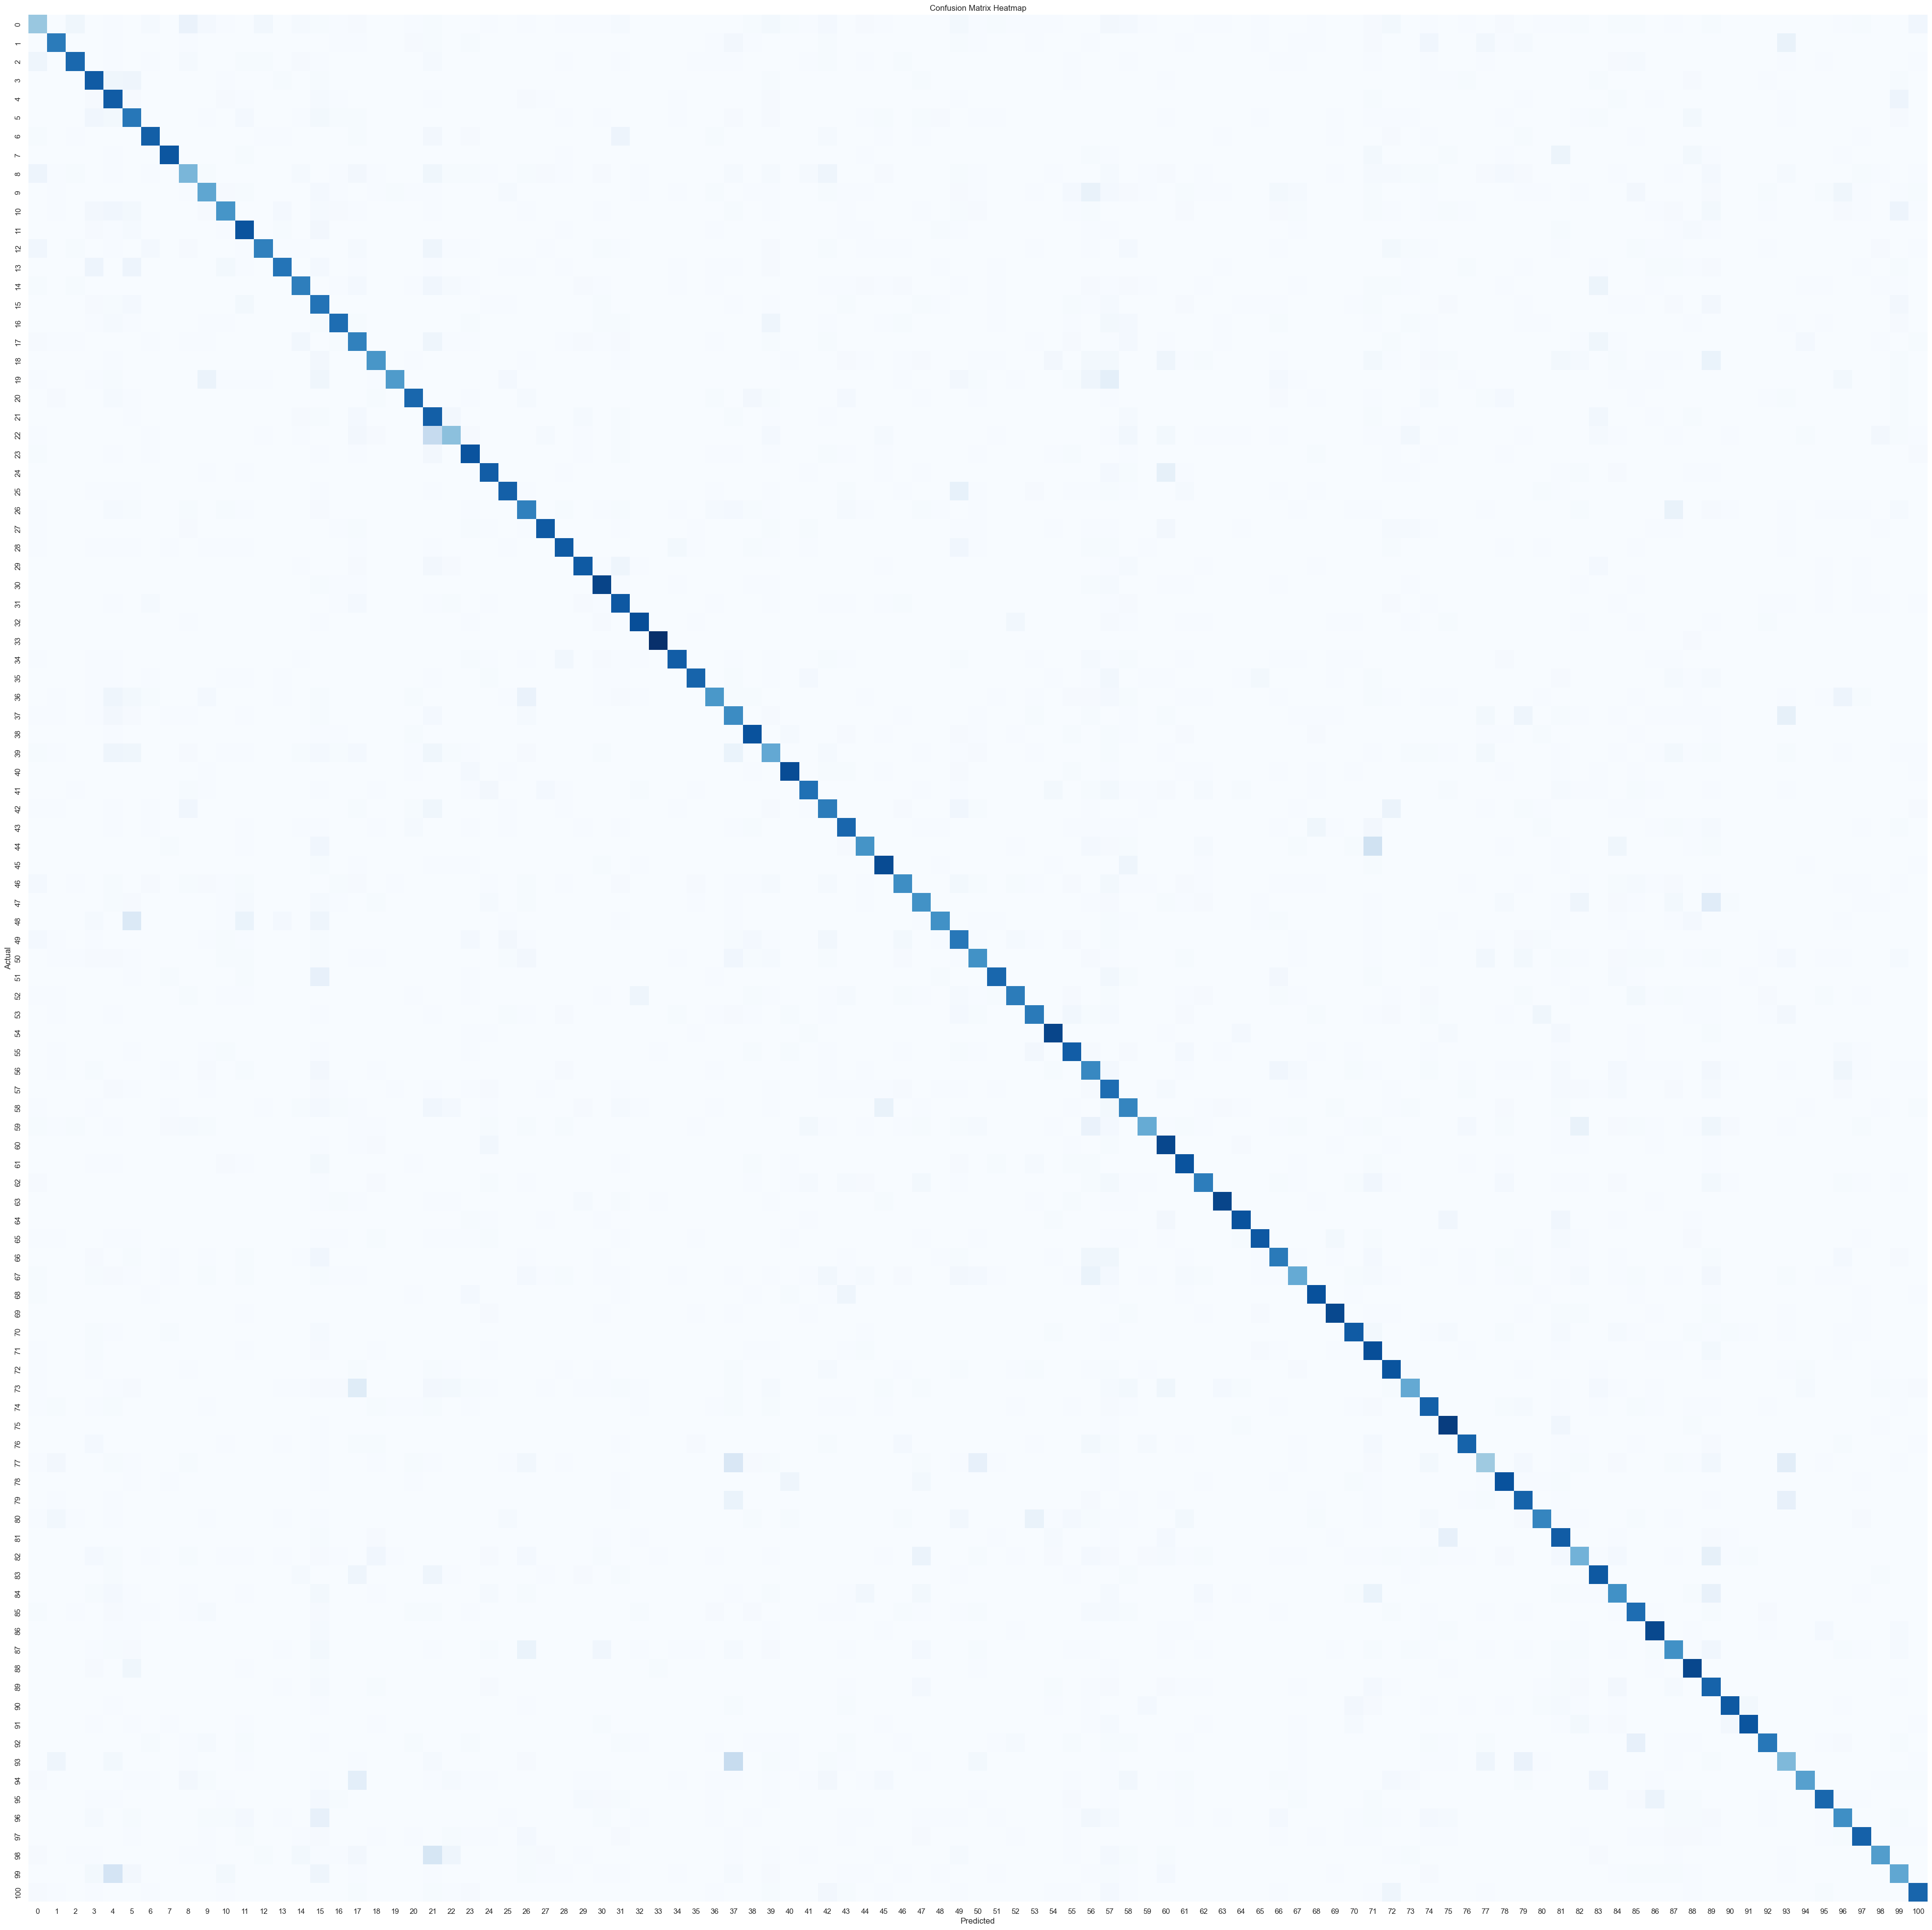

In [89]:
# Create a heatmap
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(50, 50))
plt.rcParams.update({'font.size': 60})  # Adjust font size
sns.heatmap(cm, cmap="Blues", annot=False, fmt=".2f", cbar=False)

# Add labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")